<a href="https://colab.research.google.com/github/sageradh1/3Histopathologic-Cancer-Detection-UsingNashNet-KaggleCompetition/blob/master/3main_file_with_reduced_df_for_slower_computer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
cd /content

/content


In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sagaradh","key":"4f46dcefbb5ef5683bbb915a0657eb9b"}'}

In [0]:
mkdir -p ~/.kaggle/

In [0]:
mv kaggle.json ~/.kaggle/

In [0]:
!kaggle competitions download -c histopathologic-cancer-detection --force

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 43.1MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 46.7MB/s]
 99% 1.29G/1.30G [00:11<00:00, 129MB/s]
100% 1.30G/1.30G [00:11<00:00, 120MB/s]
100% 4.98G/4.98G [00:46<00:00, 51.7MB/s]
100% 4.98G/4.98G [00:46<00:00, 114MB/s] 


In [0]:
!mkdir data

In [0]:
cd data

/content/data


In [0]:
!mkdir input & mkdir output

In [0]:
ls -a

./  ../  input/  output/


In [0]:
# System
import sys
import os
from os import path
import argparse

# Time
import time
import datetime

# Numerical Data
import random
from random import shuffle
import numpy as np 
import pandas as pd
from collections import Counter

# Tools
import shutil
from glob import glob
from tqdm import tqdm
import itertools
import gc
import json

# NLP
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight as cw
from sklearn.utils import shuffle

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Machine Learning Models
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier

# Machine Learning Evaluation
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Deep Learning - Keras -  Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Deep Learning - Keras - Model
import keras
from keras import models
from keras.models import Model
from keras.models import Sequential

# Deep Learning - Keras - Layers
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D

# Deep Learning - Keras - Pretrained Model 
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile, NASNetLarge

from keras.applications.nasnet import preprocess_input

# Deep Learning - Keras - Evauation
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy

# Deep Learning - Keras - Visualisation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
# from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

# Deep Learning - TensorFlow
import tensorflow as tf

# Graph/ Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

# Image
import cv2
from PIL import Image
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

# np.random.seed(42)

%matplotlib inline

In [0]:
cd input

/content/data/input


In [0]:
!mkdir test && mkdir train

In [0]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [0]:
input_directory = r"/content/data/input/"
output_directory = r"/content/data/output/"

training_dir = input_directory + r"train"
testing_dir = input_directory + r"test"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
figure_directory = "/content/data/output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

In [0]:
!unzip /content/train_labels.csv.zip -d /content/data/input/

Archive:  /content/train_labels.csv.zip
  inflating: /content/data/input/train_labels.csv  


In [0]:
m = {0:'Normal', 1:'Cancer'}

train_alldf = pd.read_csv(input_directory+"train_labels.csv")
train_alldf['id'] = train_alldf['id'].apply(lambda x:x+".tif")
train_alldf['label'] = train_alldf['label'].map(m)
train_alldf.head()
print(train_alldf.shape)

np.random.seed(10)

remove_n =  194800

drop_indices = np.random.choice(train_alldf.index, remove_n, replace=False)
train_df = train_alldf.drop(drop_indices)
print(train_df.shape)

(220025, 2)
(25225, 2)


In [0]:
!unzip /content/sample_submission.csv.zip -d /content/data/input/

Archive:  /content/sample_submission.csv.zip
replace /content/data/input/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: /content/data/input/sample_submission.csv  


In [0]:
test_alldf = pd.read_csv(input_directory+"sample_submission.csv")
test_alldf['id'] = test_alldf['id'].apply(lambda x:x+".tif")
test_alldf['label'] = test_alldf['label'].map(m)
test_alldf.head()
print(test_alldf.shape)


np.random.seed(10)

remove_n = 50458
#remove_n = 0
drop_indices = np.random.choice(test_alldf.index, remove_n, replace=False)
test_df = test_alldf.drop(drop_indices)
print(test_df.shape)


(57458, 2)
(7000, 2)


In [0]:
def plot_image(file, directory=None, sub=False, aspect=None):
    path = directory + file
    
    img = plt.imread(path)
    
    plt.imshow(img, aspect=aspect)
#     plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
        
def plot_img_df(directory=None, df=None, filename="id", label = "label", count=5):
    label_map = {}
    
    classes = list(set(df[label]))
    
    for l in classes:
        label_map[l] = df[df[label]==l][filename]
        label_map[l] = label_map[l].sample(count, replace=True)
        
    
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
#     print(nrows, ncols)
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for label in label_map:
        print(label)
        j=0
        for id, file in label_map[label].iteritems():
            plt.subplot(nrows, 5, j+1)
            plot_image(file, directory, aspect='auto')
            j=j+1
            
        plt.tight_layout()
        plt.show()
        
        i+=1
        
def plot_img_dir(directory=testing_dir, count=5):
    selected_files = random.sample(os.listdir(testing_dir), count)
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in selected_files:        
        plt.subplot(nrows, ncols, i+1)
        path = directory + file
        plot_image(file, directory, aspect=aspect)

        i=i+1
    
    plt.tight_layout()
    plt.show()

In [0]:
pwd

'/content/data/input'

In [0]:
cd ..

/content/data


In [0]:
!unzip /content/train.zip -d /content/data/input/train


In [0]:

!unzip /content/test.zip -d /content/data/input/test

Sample trainning images
Cancer


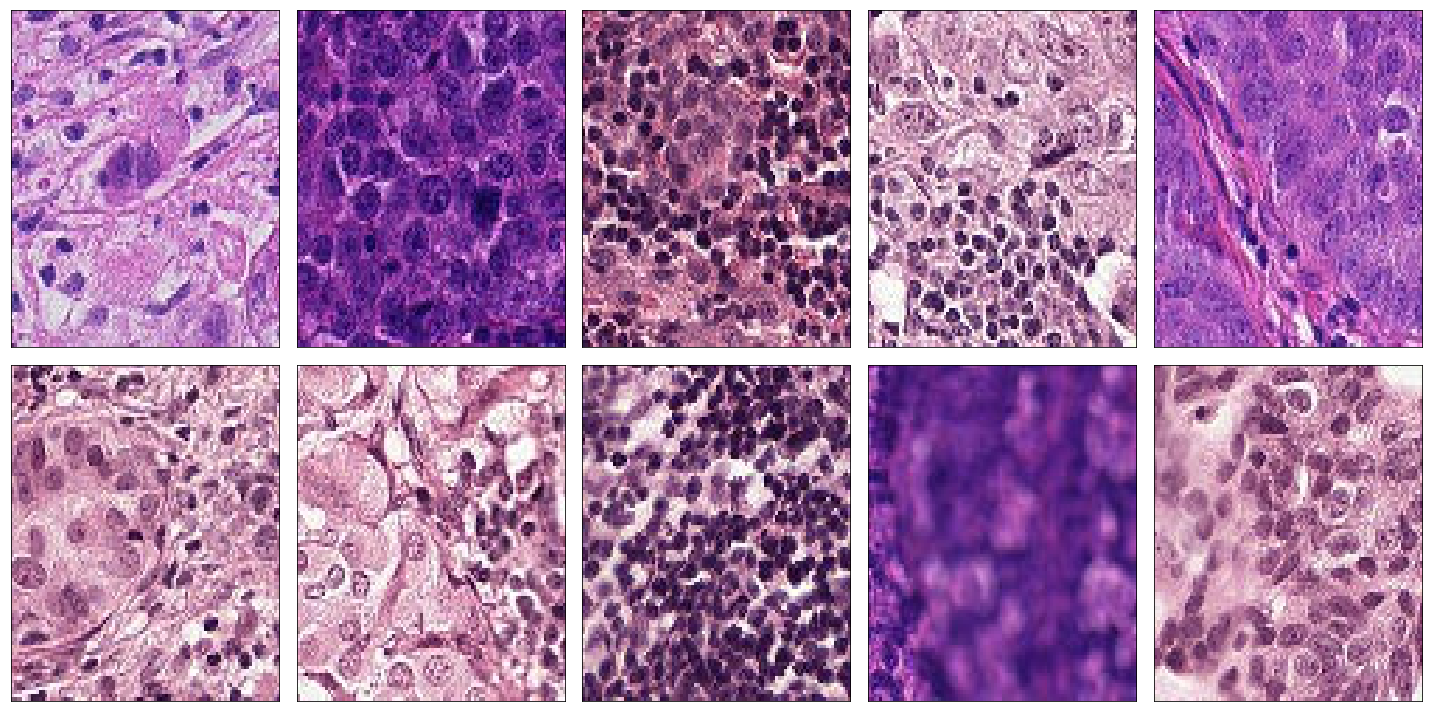

Normal


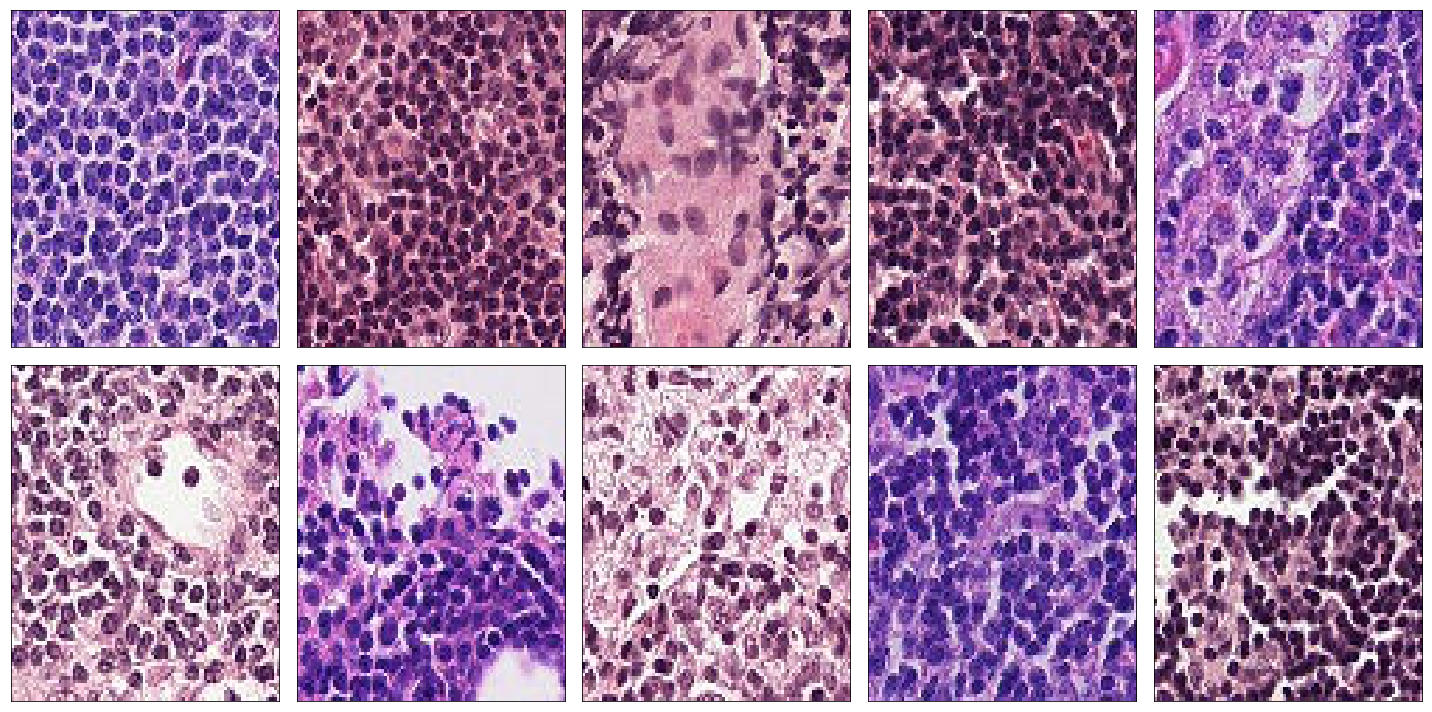

In [0]:
count = 10
print("Sample trainning images")
plot_img_df(directory=training_dir+"/", df=train_df, count=10)

In [0]:

def get_data(batch_size=32, target_size=(299, 299), class_mode="categorical", training_dir=training_dir, testing_dir=testing_dir):
    print("Generating data following preprocessing...\n")
    
    rescale = 1.0/255

    train_batch_size = batch_size
    test_batch_size = batch_size
    
    train_shuffle = True
    val_shuffle = True
    test_shuffle = False
    
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=45,
        shear_range=16,
        rescale=rescale,
        validation_split=0.25)

    train_generator = train_datagen.flow_from_dataframe(
        train_df, 
        training_dir,
        x_col='id',
        y_col='label',
        target_size=target_size, 
        class_mode=class_mode, 
        batch_size=batch_size, 
        shuffle=True, 
        seed=42,
        subset='training')
    
    validation_generator = train_datagen.flow_from_dataframe(
        train_df, 
        training_dir,
        x_col='id',
        y_col='label',  
        target_size=target_size, 
        class_mode=class_mode, 
        batch_size=batch_size, 
        shuffle=True, 
        seed=42,
        subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=rescale)
    
    test_generator = test_datagen.flow_from_dataframe(
        test_df, 
        testing_dir,
        x_col='id',
        y_col='label',
        target_size=target_size, 
        class_mode=class_mode, 
        batch_size=32, 
        shuffle=False, 
        seed=42)
    
    
    
    class_weights = get_weight(train_generator.classes)
    
    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)
    
    print("\nData batches generated.\n")
    
    
    return train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps


def get_weight(y):
    class_weight_current =  cw.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [0]:
def get_model(model_name, input_shape=(96, 96, 3), num_class=2):
    inputs = Input(input_shape)
    
    if model_name == "Xception":
        base_model = Xception(include_top=False, input_shape=input_shape)
    elif model_name == "ResNet50":
        base_model = ResNet50(include_top=False, input_shape=input_shape)
    elif model_name == "InceptionV3":
        # base_model = InceptionV3(include_top=False, input_shape=input_shape)
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == "InceptionResNetV2":
        base_model = InceptionResNetV2(include_top=False, input_shape=input_shape)
    if model_name == "DenseNet201":
        base_model = DenseNet201(include_top=False, input_shape=input_shape)
    if model_name == "NASNetMobile":
        base_model = NASNetMobile(include_top=False, input_shape=input_shape)
    if model_name == "NASNetLarge":
        base_model = NASNetLarge(include_top=False, input_shape=input_shape)
        
        
#     x = base_model.output
    
#     x = Dropout(0.5)(x)
    
#     x = GlobalAveragePooling2D()(x)

#     # x = Dense(1024, activation='relu')(x)
#     # x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     x = BatchNormalization()(x)
#     predictions = Dense(num_class, activation='softmax')(x) 
    
    
#     model = Model(inputs=base_model.input, outputs=predictions)
    
    
#     for layer in base_model.layers:
#         layer.trainable = False
        
        
#     for layer in model.layers[:249]:
#         layer.trainable = False
#     for layer in model.layers[249:]:
#         layer.trainable = True
    
#     x = base_model(inputs)
#     x = GlobalAveragePooling2D()(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.2)(x)
#     out = Dense(2, activation="softmax")(x)
#     model = Model(inputs, out)

    x = base_model(inputs)
    
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    
    out = Concatenate(axis=-1)([out1, out2, out3])
    
    out = Dropout(0.5)(out)
    out = BatchNormalization()(out)
    
    if num_class>1:
        out = Dense(num_class, activation="softmax", name="3_")(out)
    else:
        out = Dense(1, activation="sigmoid", name="3_")(out)
        
    model = Model(inputs, out)
    
    
    model.summary()
    
    return model


def get_conv_model(num_class=2, input_shape=(3,150,150)):
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=input_shape))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(num_class , activation='softmax'))

    print(model.summary())
    
    return model

In [0]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"

try:
    os.mkdir(main_model_dir)
except:
    print("Could not create main model directory")
    
try:
    os.mkdir(main_log_dir)
except:
    print("Could not create main log directory")



model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')


try:
    os.mkdir(model_dir)
except:
    print("Could not create model directory")
    
try:
    os.mkdir(log_dir)
except:
    print("Could not create log directory")
    
model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

Could not create main model directory
Could not create main log directory


In [0]:
print("Settting Callbacks")

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=1,
    verbose=1)

callbacks = [reduce_lr, early_stopping, checkpoint]

callbacks = [checkpoint, reduce_lr, early_stopping]

print("Set Callbacks at ", date_time(1))

Settting Callbacks
Set Callbacks at  Timestamp: 2019-07-01 13:35:03


In [0]:
print("Getting Base Model", date_time(1))

# input_shape = (96, 96, 3)
input_shape = (224, 224, 3)

num_class = 2

model = get_model(model_name="NASNetMobile", input_shape=input_shape, num_class=num_class)


Getting Base Model Timestamp: 2019-07-01 13:35:05


W0701 13:36:26.685396 140556897867648 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
NASNet (Model)                  (None, 7, 7, 1056)   4269716     input_3[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
flatten_1 

In [0]:
loss = 'categorical_crossentropy'
# loss = 'binary_crossentropy'
metrics = ['acc']
# metrics = [auroc]

In [0]:
# batch_size = 32
batch_size = 10
class_mode = "categorical"
# class_mode = "binary"
# target_size=(96, 96)
target_size=(224, 224)

train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size, target_size=target_size, class_mode=class_mode)

Generating data following preprocessing...

Found 18919 validated image filenames belonging to 2 classes.
Found 6306 validated image filenames belonging to 2 classes.
Found 7000 validated image filenames belonging to 1 classes.

Data batches generated.



In [0]:
print("Starting...\n")

start_time = time.time()
print(date_time(1))

# batch_size = 32
# train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size)

print("\n\nCompliling Model ...\n")
learning_rate = 0.0001
optimizer = Adam(learning_rate)
# optimizer = Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# steps_per_epoch = 180
# validation_steps = 40

verbose = 1
epochs = 10

print("Trainning Model ...\n")
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weights)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
# print("Elapsed Time/Epoch: " + elapsed_time/epochs)
print("Completed Model Trainning", date_time(1))

W0701 11:29:59.609185 140695918929792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Starting...

Timestamp: 2019-07-01 11:29:59


Compliling Model ...

Trainning Model ...



W0701 11:30:00.043309 140695918929792 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
592/592 [==============================] - 662s 1s/step - loss: 0.4986 - acc: 0.7958 - val_loss: 0.4571 - val_acc: 0.8346
Epoch 2/10
592/592 [==============================] - 590s 996ms/step - loss: 0.3987 - acc: 0.8449 - val_loss: 0.5505 - val_acc: 0.8262

Epoch 00002: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.
Epoch 3/10
592/592 [==============================] - 588s 993ms/step - loss: 0.3390 - acc: 0.8683 - val_loss: 0.3862 - val_acc: 0.8722
Epoch 4/10
592/592 [==============================] - 588s 992ms/step - loss: 0.3071 - acc: 0.8784 - val_loss: 0.3758 - val_acc: 0.8847
Epoch 5/10
592/592 [==============================] - 589s 994ms/step - loss: 0.2876 - acc: 0.8879 - val_loss: 0.3867 - val_acc: 0.8996

Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.
Epoch 6/10
592/592 [==============================] - 589s 995ms/step - loss: 0.2667 - acc: 0.8951 - val_loss: 0.3168 - val_acc: 0.9039
Epoch 7/10
592/592 [=====

In [0]:
def plot_performance(history=None, figure_directory=None):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    ylim_pad = [0.01, 0.1]


    plt.figure(figsize=(20, 5))

    # Plot training & validation Accuracy values

    y1 = history.history['acc']
    y2 = history.history['val_acc']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()


    # Plot training & validation loss values

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

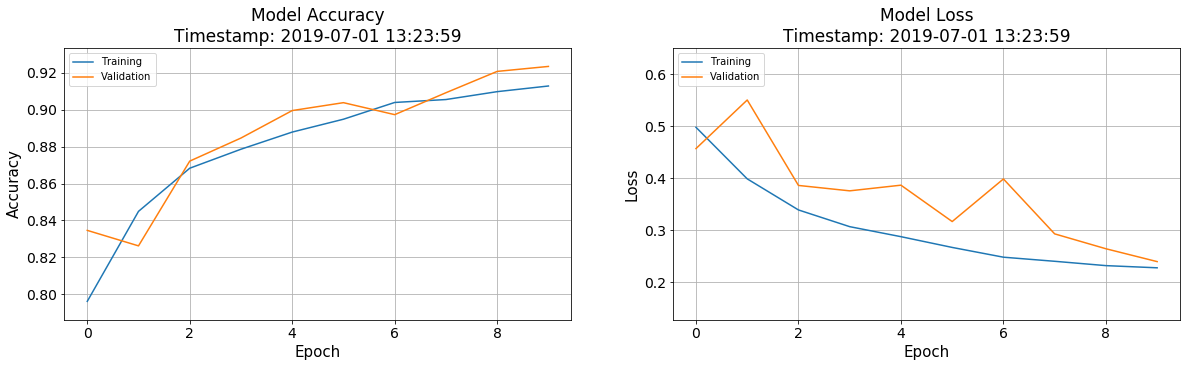

In [0]:
plot_performance(history=history)

In [0]:
ypreds = model.predict_generator(generator=test_generator, steps = len(test_generator),  verbose=1)

219/219 [==============================] - 54s 245ms/step


In [0]:

ypred = ypreds[:,1]

In [0]:
sample_df = pd.read_csv(input_directory+"sample_submission.csv")

np.random.seed(10)
remove_n = 50458
#remove_n = 0
drop_indices = np.random.choice(sample_df.index, remove_n, replace=False)
sample_df = sample_df.drop(drop_indices)
print(sample_df.shape)



sample_list = list(sample_df.id)

pred_dict = dict((key, value) for (key, value) in zip(test_generator.filenames, ypred))

pred_list_new = [pred_dict[f+'.tif'] for f in sample_list]

test_df = pd.DataFrame({'id':sample_list,'label':pred_list_new})

test_df.to_csv('submission.csv', header=True, index=False)

(7000, 2)


In [0]:
test_df.head()

,id,label
0,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.297822
1,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.365366
2,4f7710b24b9b776f6bfc89fad5469592d18e5431,0.917138
3,dd52e9ad03e746aff71b1d81c1cf168ec6dcdf57,0.719665
4,2ade3ffdc58a97d8a02fc968fb28de10de1c53da,0.808661
